In [1]:
#cd t:\freely_moving_ephys\ephys_recordings\101120\G6H28P6LT\hf4_wn
#cd \\niell-v2-w7\freely_moving_ephys\ephys_recordings\092820\J524RT\outputs_Oct07a
#cd t:\freely_moving_ephys\ephys_recordings\101520\G6H28P6LT\hf1_wn


In [2]:
cd t:\freely_moving_ephys\ephys_recordings\113020\G6H27P8LT\fm1

t:\freely_moving_ephys\ephys_recordings\113020\G6H27P8LT\fm1


In [3]:
eye_file =   "101120_G6H28P6LT_hf4_wnReye.nc"
world_file = '101120_G6H28P6LT_hf4_wnworld.nc'
ephys_file = '101120_G6H28P6LT_hf4_wn_ephys.json'

eye_file = '092820_J524RT_whitenoise_hfReye.nc'
world_file = '092820_J524RT_whitenoise_hfworld.nc'
ephys_file = '092820_J524RT_whitenoise_hf_ephys.json'

eye_file =   "101420_G6H28P6LT_hf1_wnReye.nc"
world_file = '101420_G6H28P6LT_hf1_wnworld.nc'
ephys_file = '101420_G6H28P6LT_hf1_wn_ephys_merge.json'

eye_file =   "101420_G6H28P6LT_h2_wn_Reye.nc"
world_file = '101420_G6H28P6LT_h2_wn_world.nc'
ephys_file = '101420_G6H28P6LT_h2_wn_ephys_merge.json'

#name_base = '112920_G6H27P8LT_control_Rig2_hf1_wn'
name_base = '113020_G6H27P8LT_control_Rig2_fm1'

eye_file = name_base + '_Reye.nc'
world_file = name_base + '_world.nc'
ephys_file = name_base + '_ephys_merge.json'
imu_file = name_base + "_imu.nc"
speed_file = name_base + "_speed.nc"

free_move = True;

In [4]:
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pickle
import time
import subprocess
from matplotlib.animation import FFMpegWriter
import matplotlib as mpl 
import wavio
mpl.rcParams['animation.ffmpeg_path'] = r'C:\Program Files\ffmpeg\bin\ffmpeg.exe'
from scipy.interpolate import interp1d
from numpy import nan

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## load worldcam

In [5]:
# load worldcam
world_data = xr.open_dataset(world_file)
world_vid_raw = np.uint8(world_data['WORLD_video'])



In [6]:
#resize worldcam to make more manageable
sz = world_vid_raw.shape
downsamp = 0.5
world_vid = np.zeros((sz[0],np.int(sz[1]*downsamp),np.int(sz[2]*downsamp)), dtype = 'uint8')
for f in range(sz[0]):
    world_vid[f,:,:] = cv2.resize(world_vid_raw[f,:,:],(np.int(sz[2]*downsamp),np.int(sz[1]*downsamp)))
worldT = world_data.timestamps.copy()
world_data

<xarray.Dataset>
Dimensions:      (frame: 107305, height: 240, width: 320)
Coordinates:
  * frame        (frame) int64 0 1 2 3 4 ... 107300 107301 107302 107303 107304
    timestamps   (frame) float64 ...
Dimensions without coordinates: height, width
Data variables:
    WORLD_times  (frame) float64 ...
    WORLD_video  (frame, height, width) int8

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0, 'deltaT')

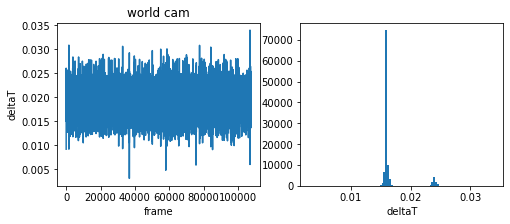

In [7]:
# plot worldcam timing
fig, axs = plt.subplots(1,2,figsize=(8,3))
axs[0].plot(np.diff(worldT)); axs[0].set_xlabel('frame'); axs[0].set_ylabel('deltaT'); axs[0].set_title('world cam')
axs[1].hist(np.diff(worldT),100);axs[1].set_xlabel('deltaT')

Text(0.5, 1.0, 'mean worldcam')

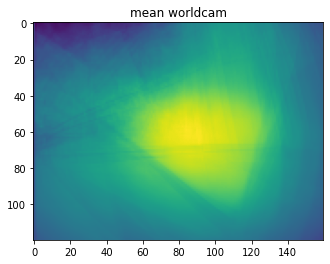

In [8]:
# plot mean world image
plt.imshow(np.mean(world_vid,axis=0)); plt.title('mean worldcam')

In [9]:
# load IMU data
if free_move:
    imu_data = xr.open_dataset(imu_file)
    accT = imu_data.timestamps;
    acc_chans = imu_data['__xarray_dataarray_variable__']
    gx = np.array(acc_chans.sel(channel='gyro_x'))
    gy = np.array(acc_chans.sel(channel='gyro_y'))
    gz = np.array(acc_chans.sel(channel='gyro_z'))


In [10]:
#load optical mouse data
if free_move == False:
    speed_data = xr.open_dataset(speed_file)
    spdVals = speed_data['__xarray_dataarray_variable__']
    spd = spdVals.sel(move_params = 'cm_per_sec')*10  # need to check conversion factor
    spd_tstamps = spdVals.sel(move_params = 'timestamps')
    plt.plot(spd_tstamps,spd)
    plt.xlabel('sec'); plt.ylabel('running speed cm/sec')


In [11]:
free_move == False

False

In [12]:
# read ephys data
ephys_data = pd.read_json(ephys_file)
ephys_data


,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh,waveform,spikeT,t0
0,831.8,766.3,mua,38.779800,0,1,0.049973,noise,152,0,"[0.021200126, 0.0042820089, 0.006965057, 0.007...","[16.3708333333, 36.9003333333, 44.4680666667, ...",41548.159859
1,280.2,38.3,mua,20.010872,3,76,4.739199,noise,14415,0,"[0.0482882597, 0.047045473000000004, 0.0448711...","[1.9473666667, 3.3407333333, 4.0323666667, 4.2...",41548.159859
2,532.0,452.2,mua,35.837986,2,51,0.059507,noise,181,0,"[-0.0248870458, -0.0280647129, -0.0328201316, ...","[9.0919, 9.168, 17.5761, 42.3620666667, 56.390...",41548.159859
3,1972.0,975.0,mua,36.393227,6,151,0.010192,noise,31,0,"[0.012948445000000001, 0.0351695046, 0.0400991...","[323.8967, 323.8972333333, 588.6788666667, 588...",41548.159859
4,1168.7,1657.5,mua,29.147697,0,1,0.012822,noise,39,0,"[-0.0095937969, -0.0073385406, -0.0070729619, ...","[122.6954, 122.6957, 122.6960666667, 207.25436...",41548.159859
...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,2070.7,0.0,good,66.090561,59,676,2.447024,noise,7443,0,"[0.0234736931, 0.0415179431, 0.039258651400000...","[0.0023333333, 0.1492, 0.3381666667, 0.4598333...",41548.159859
203,1656.4,7.3,good,76.581085,61,726,0.640770,noise,1949,0,"[0.0275271349, 0.0469120517, 0.0445312448, 0.0...","[9.3006, 11.7851666667, 34.2747666667, 46.2582...",41548.159859
204,1239.6,27.8,mua,90.319221,60,701,4.138539,mua,12588,0,"[0.0117258364, 0.0190299302, 0.0169364475, 0.0...","[0.4586333333, 1.0920333333, 4.2657666667, 4.7...",41548.159859
205,923.9,0.0,good,59.331085,55,576,0.255782,noise,778,0,"[0.028043812100000003, 0.0486460105, 0.0465628...","[19.8554333333, 25.1244, 25.5862333333, 38.291...",41548.159859


In [13]:
# get intitial ephys timepoint (t0)
ephysT0 = ephys_data.iloc[0,12]
ephysT0 

41548.159859

In [14]:
# select good cells from phy2
goodcells = ephys_data.loc[ephys_data['group']=='good']
goodcells.shape
units = goodcells.index.values


In [15]:
# get number of good units
n_units = len(goodcells)
print(n_units)

19


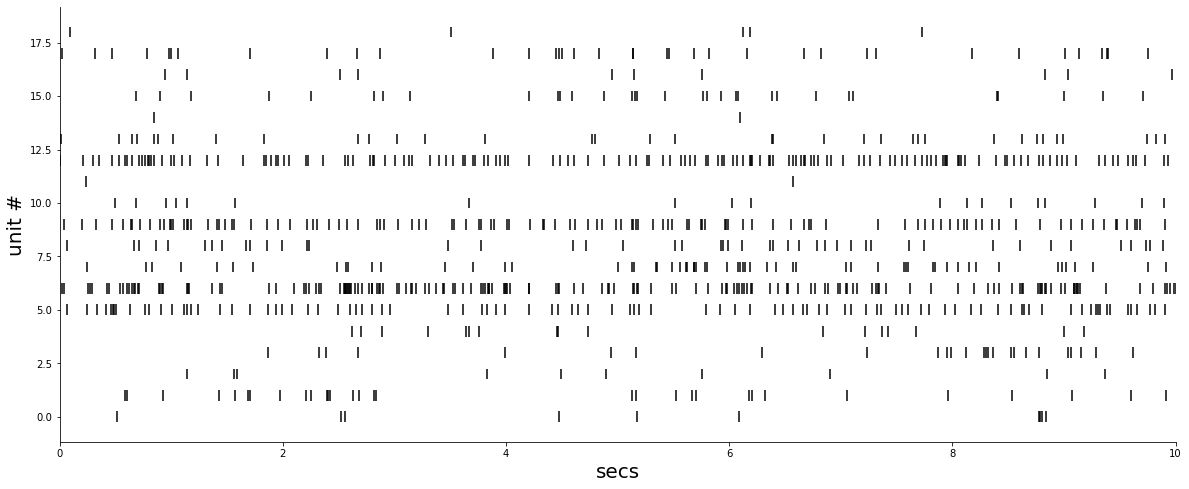

In [16]:
#spike rasters
fig, ax = plt.subplots(figsize=(20,8))
ax.fontsize = 20
for i,ind in enumerate(goodcells.index):
   plt.vlines(goodcells.at[ind,'spikeT'],i-0.25,i+0.25)
   plt.xlim(0, 10); plt.xlabel('secs',fontsize = 20); plt.ylabel('unit #',fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('spikeraster.pdf')



<xarray.DataArray 'timestamps' (frame: 107302)>
array([41547.17187775, 41547.18670025, 41547.20272575, ...,
       43337.45624325, 43337.47226875, 43337.48829425])
Coordinates:
  * frame       (frame) int64 0 1 2 3 4 5 ... 107297 107298 107299 107300 107301
    timestamps  (frame) float64 4.155e+04 4.155e+04 ... 4.334e+04 4.334e+04

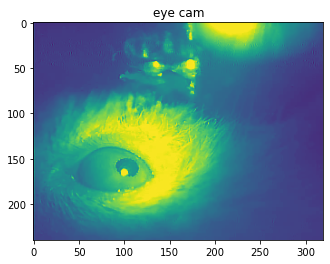

In [17]:
#load eye data
eye_data = xr.open_dataset(eye_file)
eye_vid = np.uint8(eye_data['REYE_video'])
plt.imshow(eye_vid[0,:,:]); plt.title('eye cam')
eyeT = eye_data.timestamps.copy()
eyeT

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


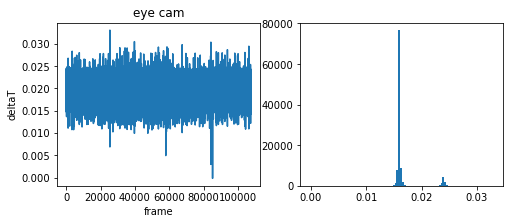

In [18]:
# plot eye timestamps
fig, axs = plt.subplots(1,2,figsize=(8,3))
axs[0].plot(np.diff(eyeT)); axs[0].set_xlabel('frame'); axs[0].set_ylabel('deltaT'); axs[0].set_title('eye cam')
axs[1].hist(np.diff(eyeT),100);

Text(0, 0.5, 'phi')

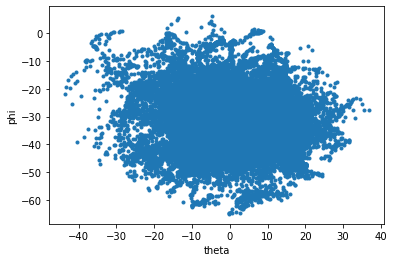

In [19]:
#plot eye postion across recording
eye_params = eye_data['REYE_ellipse_params']
plt.plot(eye_params.sel(ellipse_params = 'theta')*180/3.1415,eye_params.sel(ellipse_params = 'phi')*180/3.1415,'.')
plt.xlabel('theta'); plt.ylabel('phi')

In [20]:
eye_data

<xarray.Dataset>
Dimensions:                  (deg: 360, ellipse_params: 7, frame: 107302, height: 240, point_loc: 30, shift: 1, width: 320)
Coordinates:
  * frame                    (frame) int64 0 1 2 3 ... 107299 107300 107301
  * point_loc                (point_loc) object 'pt1_x' ... 'outer_likelihood'
    timestamps               (frame) float64 ...
  * ellipse_params           (ellipse_params) object 'theta' ... 'ellipse_phi'
  * shift                    (shift) int64 0
Dimensions without coordinates: deg, height, width
Data variables:
    REYE_pts                 (frame, point_loc) float64 ...
    REYE_ellipse_params      (frame, ellipse_params) float64 ...
    REYE_video               (frame, height, width) int8 
    REYE_radius_fit          (frame, deg) float64 ...
    REYE_radius_fit_conv     (frame, deg) float64 ...
    REYE_eye_pupil_rotation  (frame, shift) float64 ...

In [21]:
# adjust eye/world/top times relative to ephys
eyeT = eye_data.timestamps  - ephysT0
if eyeT[0]<-600:
    eyeT = eyeT + 8*60*60 # 8hr offset for some data
worldT = world_data.timestamps - ephysT0
if worldT[0]<-600:
    worldT = worldT + 8*60*60
if free_move:
    accT = imu_data.timestamps-ephysT0
if free_move==False:
    speedT = spd_tstamps-ephysT0
eyeT, worldT

(<xarray.DataArray 'timestamps' (frame: 107302)>
 array([-9.87981250e-01, -9.73158750e-01, -9.57133250e-01, ...,
         1.78929638e+03,  1.78931241e+03,  1.78932844e+03])
 Coordinates:
   * frame       (frame) int64 0 1 2 3 4 5 ... 107297 107298 107299 107300 107301
     timestamps  (frame) float64 4.155e+04 4.155e+04 ... 4.334e+04 4.334e+04,
 <xarray.DataArray 'timestamps' (frame: 107305)>
 array([-9.97978250e-01, -9.88825750e-01, -9.72800250e-01, ...,
         1.78930450e+03,  1.78932044e+03,  1.78933646e+03])
 Coordinates:
   * frame       (frame) int64 0 1 2 3 4 5 ... 107300 107301 107302 107303 107304
     timestamps  (frame) float64 4.155e+04 4.155e+04 ... 4.334e+04 4.334e+04)

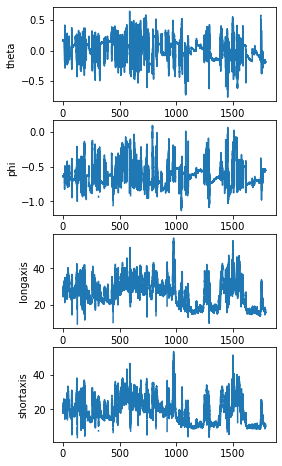

In [22]:
#plot eye variables
fig,axs = plt.subplots(4,1,figsize = (4,8))
for i,val in enumerate(eye_params.ellipse_params[0:4]):
    axs[i].plot(eyeT,eye_params.sel(ellipse_params = val))
    axs[i].set_ylabel(val.values)
    

In [23]:
# calculate eye veloctiy
dEye = np.diff(eye_params.sel(ellipse_params = 'theta'))*180/np.pi
eye_vid.shape

(107302, 240, 320)

Text(0, 0.5, 'contrast')

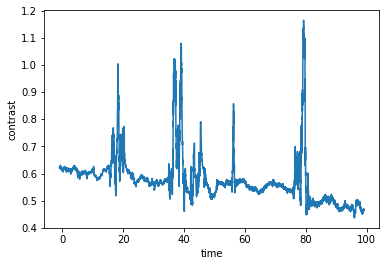

In [24]:
# normalize world movie and calculate contrast

std_im = np.std(world_vid,axis=0);
std_im[std_im<10] = 10;
img_norm = (world_vid-np.mean(world_vid,axis=0))/std_im

contrast = np.empty(worldT.size)
for i in range(worldT.size):
    contrast[i] = np.std(img_norm[i,:,:])
plt.plot(worldT[0:6000],contrast[0:6000])
plt.xlabel('time')
plt.ylabel('contrast')

In [25]:
# set up interpolators for eye and world videos
eyeInterp = interp1d(eyeT,eye_vid,axis=0)
worldInterp = interp1d(worldT,world_vid,axis=0)

NameError: name 'speedT' is not defined

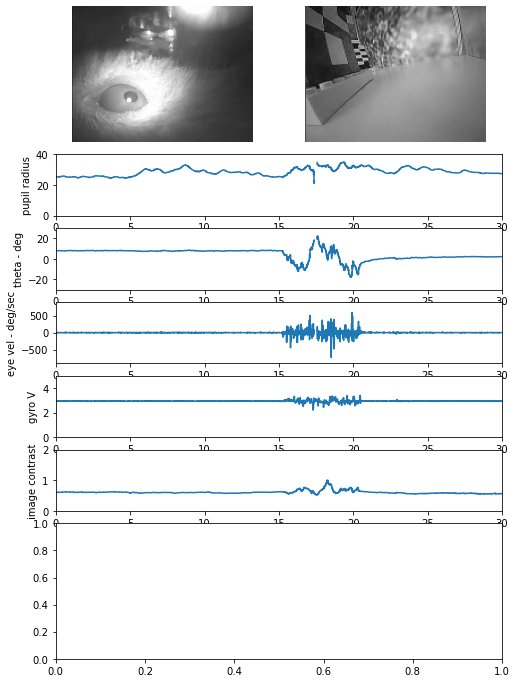

In [26]:
# make movie and sound

#unit to plot/record
this_unit = 1

#set up figure
fig = plt.figure(figsize = (8,12))
gs = fig.add_gridspec(9,4)
axEye = fig.add_subplot(gs[0:2,0:2])
axWorld = fig.add_subplot(gs[0:2,2:4])

axRad = fig.add_subplot(gs[2,:])
axTheta = fig.add_subplot(gs[3,:])
axdTheta = fig.add_subplot(gs[4,:])
axGyro = fig.add_subplot(gs[5,:])
axContrast = fig.add_subplot(gs[6,:])
axR = fig.add_subplot(gs[7:9,:])
#axRad = fig.add_subplot(gs[3,:])

#timerange and center frame (only)
tr = [0, 30]
fr = np.mean(tr) # time for frame
eyeFr = np.abs(eyeT-fr).argmin(dim = "frame")
worldFr = np.abs(worldT-fr).argmin(dim = "frame")

axEye.cla(); axEye.axis('off'); 
axEye.imshow(eye_vid[eyeFr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")
#axEye.plot(eye_params.sel(ellipse_params = 'X0')[fr]/2,eye_params.sel(ellipse_params = 'Y0')[fr]/2,'r.')
#axEye.set_xlim(0,160); axEye.set_ylim(0,120)

axWorld.cla();  axWorld.axis('off'); 
axWorld.imshow(world_vid[worldFr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")

# plot contrast
axContrast.plot(worldT,contrast)
axContrast.set_xlim(tr[0],tr[1]); axContrast.set_ylim(0,2)
axContrast.set_ylabel('image contrast')


#plot radius
axRad.cla()
axRad.plot(eyeT,eye_params.sel(ellipse_params = 'longaxis'))
axRad.set_xlim(tr[0],tr[1]); 
axRad.set_ylabel('pupil radius'); axRad.set_xlabel('frame #'); axRad.set_ylim(0,40)

#plot eye position
axTheta.cla()
axTheta.plot(eyeT,(eye_params.sel(ellipse_params = 'theta')-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
axTheta.set_xlim(tr[0],tr[1]); 
axTheta.set_ylabel('theta - deg'); axTheta.set_ylim(-30,30)

# plot eye velocity
axdTheta.cla()
axdTheta.plot(eyeT[0:-1],dEye*60); ax.set_ylabel('dtheta')
#sacc = np.transpose(np.where(np.abs(dEye)>10))
#axdTheta.plot(sacc,np.sign(dEye[sacc])*20,'.')
axdTheta.set_xlim(tr[0],tr[1]); 
axdTheta.set_ylim(-900,900); axdTheta.set_ylabel('eye vel - deg/sec')

# plot gyro
if free_move:
    axGyro.plot(accT,gz)
    axGyro.set_xlim(tr[0],tr[1]); axGyro.set_ylim(0,5)
    axGyro.set_ylabel('gyro V')

if free_move==False:
    axGyro.plot(speedT,spd)
    axGyro.set_xlim(tr[0],tr[1]); axGyro.set_ylim(0,20)
    axGyro.set_ylabel('speed cm/sec')   
    
    
# plot spikes
axR.fontsize = 20
for i,ind in enumerate(goodcells.index):
    axR.vlines(goodcells.at[ind,'spikeT'],i-0.25,i+0.25,'k',linewidth=0.5)
axR.vlines(goodcells.at[units[this_unit],'spikeT'],this_unit-0.25,this_unit+0.25,'b',linewidth=0.5)

axR.set_xlim(tr[0],tr[1]); axR.set_ylim(-0.5 , n_units); axR.set_xlabel('secs'); axR.set_ylabel('unit #')
axR.spines['right'].set_visible(False)
axR.spines['top'].set_visible(False)

plt.tight_layout()


plt.savefig(name_base + '_eye_spikes.pdf')

vidfile = name_base + '_' + str(this_unit) + '.mp4'
# now animate
writer = FFMpegWriter(fps=30)
with writer.saving(fig, vidfile, 100):
    for t in np.arange(tr[0],tr[1],1/30):
        
        # show eye and world frames
        axEye.cla(); axEye.axis('off'); 
        axEye.imshow(eyeInterp(t),'gray',vmin=0,vmax=255,aspect = "equal")
        #axEye.set_xlim(0,160); axEye.set_ylim(0,120)
        
        axWorld.cla(); axWorld.axis('off'); 
        axWorld.imshow(worldInterp(t),'gray',vmin=0,vmax=255,aspect = "equal")
        
        #plot line for time, then remove
        ln = axR.vlines(t,-0.5,30,'b')
        writer.grab_frame()
        ln.remove()
        
###



# generate wave file
sp =np.array(ephys_data.at[units[this_unit],'spikeT'])-tr[0]
sp = sp[sp>0]
datarate = 30000

# Compute waveform samples
tmax = tr[1]-tr[0]
t = np.linspace(0, tr[1]-tr[0], (tr[1]-tr[0])*datarate,endpoint=False)
x = np.zeros(np.size(t))
for spt in sp[sp<tmax]:
    x[np.int64(spt*datarate) : np.int64(spt*datarate +30)] = 1
    x[np.int64(spt*datarate)+31 : np.int64(spt*datarate +60)] =- 1
plt.plot(x)
    

# Write the samples to a file
audfile = name_base + '_' + str(this_unit) + '.wav'
wavio.write(audfile, x, datarate, sampwidth=1)

In [ ]:
# merge video and audio
subprocess.call([r'C:\Program Files\ffmpeg\bin\ffmpeg.exe', '-i', vidfile, '-i', audfile, '-c:v', 'copy', '-c:a', 'aac', vidfile[0:-4] + '_merge.mp4']) 

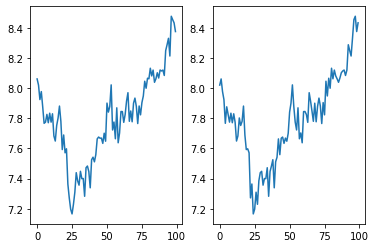

In [63]:
th = np.array((eye_params.sel(ellipse_params = 'theta')-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
phi = np.array((eye_params.sel(ellipse_params = 'phi')-np.nanmean(eye_params.sel(ellipse_params = 'phi')))*180/3.14159)
th_switch = np.zeros(np.shape(th))
th_switch[0:-1:2] = np.array(th[1::2])
th_switch[1::2] = np.array(th[0:-1:2])
plt.subplot(1,2,1)
plt.plot(th[500:600])
plt.subplot(1,2,2)
plt.plot(th_switch[500:600])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:684: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


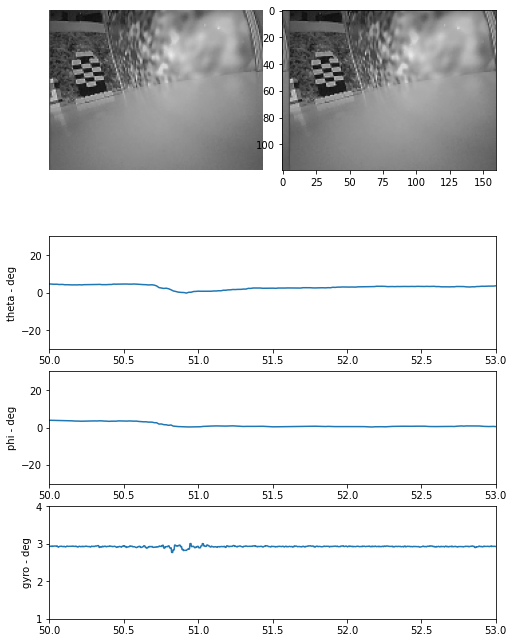

In [79]:
tr = [50,53]
fig = plt.figure(figsize = (8,12))
gs = fig.add_gridspec(5,4)
#axEye = fig.add_subplot(gs[0,0])
axWorld = fig.add_subplot(gs[0:2,0:2])
axWorldFix = fig.add_subplot(gs[0:2,2:4])

axTheta = fig.add_subplot(gs[2,:])
axPhi = fig.add_subplot(gs[3,:])
axGyro = fig.add_subplot(gs[4,:])

th = np.array((eye_params.sel(ellipse_params = 'theta')-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
phi = np.array((eye_params.sel(ellipse_params = 'phi')-np.nanmean(eye_params.sel(ellipse_params = 'phi')))*180/3.14159)

axTheta.plot(eyeT,th_switch)
axTheta.set_xlim(tr[0],tr[1]); 
axTheta.set_ylabel('theta - deg'); axTheta.set_ylim(-30,30)

axPhi.plot(eyeT,phi)
axPhi.set_xlim(tr[0],tr[1]); 
axPhi.set_ylabel('phi - deg'); axPhi.set_ylim(-30,30)

if free_move:
    axGyro.plot(accT,gz)
    axGyro.set_xlim(tr[0],tr[1]); 
    axGyro.set_ylabel('gyro - deg'); axGyro.set_ylim(1,4)

thInterp =interp1d(eyeT,th_switch)
phiInterp =interp1d(eyeT,phi)
pix_per_deg = 1.6;

vidfile = name_base + '_corrected_' + str(this_unit) + '.mp4'
# now animate
writer = FFMpegWriter(fps=30)
with writer.saving(fig, vidfile, 100):
    for t in np.arange(tr[0],tr[1],1/30):
        
        
        # show eye and world frames
        axEye.cla(); axEye.axis('off'); 
        axEye.imshow(eyeInterp(t),'gray',vmin=0,vmax=255,aspect = "equal")
        #axEye.set_xlim(0,160); axEye.set_ylim(0,120)
        
        world = worldInterp(t)
        axWorld.cla(); axWorld.axis('off'); 
        axWorld.imshow(world,'gray',vmin=0,vmax=255,aspect = "equal")
        
        worldFix= np.roll(world,(-np.int8(phiInterp(t)*pix_per_deg),np.int8(thInterp(t)*pix_per_deg)),axis = (0,1))
        axWorldFix.imshow(worldFix,'gray',vmin=0, vmax = 255, aspect = 'equal')
        
        #plot line for time, then remove
        ln1 = axTheta.vlines(t,-0.5,30,'b')
        ln2 = axPhi.vlines(t,-0.5,30,'b')
        writer.grab_frame()
        ln1.remove()
        ln2.remove()


Text(0.5, 0, 'secs')

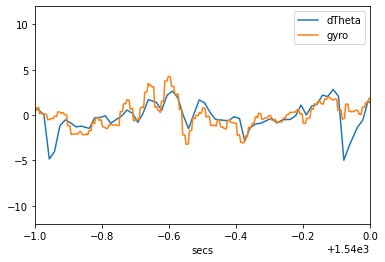

In [98]:
if free_move:
    plt.plot(eyeT[0:-1],np.diff(th_switch),label = 'dTheta')
    plt.plot(accT-0.1,(gz-3)*10, label = 'gyro')
    plt.xlim(30:40); plt.ylim(-12,12); plt.legend(); plt.xlabel('secs')

In [ ]:
plt.subplot(1,2,1)
plt.imshow(std_im)
plt.title('std dev of image')
plt.subplot(1,2,2)
plt.imshow(np.mean(world_vid,axis=0),vmin=0,vmax=255)
plt.title('mean of image')

In [ ]:
#calculate image contrast
contrast = np.empty(worldT.size)
for i in range(worldT.size):
    contrast[i] = np.std(img_norm[i,:,:])
plt.plot(worldT[0:12000],contrast[0:12000])
plt.xlabel('time')
plt.ylabel('contrast')


In [67]:
#set up timebase for subsequent analysis
dt = 0.025
t = np.arange(0, np.max(worldT),dt)

In [ ]:
# interpolate and plot contrast
newc =interp1d(worldT,contrast)
contrast_interp = newc(t[0:-1])
contrast_interp.shape
plt.plot(t[0:600],contrast_interp[0:600])
plt.xlabel('secs'); plt.ylabel('contrast')

In [68]:
# calculate firing rate at new timebase
ephys_data['rate'] = nan
ephys_data['rate'] = ephys_data['rate'].astype(object)
for i,ind in enumerate(ephys_data.index):
    ephys_data.at[ind,'rate'],bins = np.histogram(ephys_data.at[ind,'spikeT'],t)
ephys_data['rate']= ephys_data['rate']/dt
goodcells = ephys_data.loc[ephys_data['group']=='good']
goodcells

,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh,waveform,spikeT,t0,rate
14,1560.7,38.0,mua,76.501175,13,326,3.180178,good,9673,0,"[0.0318300724, 0.0303256121, 0.0319133699, 0.0...","[0.5182, 2.5244, 2.5544000000000002, 4.4746, 5...",41548.159859,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
19,1108.6,19.5,mua,63.576565,15,376,5.009118,good,15236,0,"[0.035081155600000004, 0.0336350799, 0.0354663...","[0.5846, 0.6036666667, 0.9296000000000001, 1.4...",41548.159859,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
20,1054.0,4.9,good,84.590919,15,376,4.459088,good,13563,0,"[0.0467762202, 0.0439777412, 0.047026954600000...","[1.1385666667, 1.5590000000000002, 1.585866666...",41548.159859,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
38,893.4,15.0,mua,64.314270,19,476,4.648459,good,14139,0,"[0.0441444665, 0.0427553654, 0.0452394299, 0.0...","[1.8707, 2.3285333333000002, 2.3909333333, 2.6...",41548.159859,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
45,1052.8,17.0,mua,75.534012,21,526,4.429170,good,13472,0,"[0.0477663875, 0.046341244100000005, 0.0492711...","[2.6173666667, 2.7019, 2.8875333333, 3.3004333...",41548.159859,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
60,1478.9,6.7,good,67.629257,25,626,9.382069,good,28537,0,"[0.0345240906, 0.033132337000000005, 0.0354509...","[0.0625666667, 0.2486666667, 0.3310333333, 0.4...",41548.159859,"[0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
114,1383.5,1.0,good,90.567123,49,426,38.279181,good,116432,0,"[0.0066352603, 0.0042942865, 0.004391727000000...","[0.0174333333, 0.0408666667, 0.2554333333, 0.2...",41548.159859,"[40.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
130,895.0,8.1,good,74.902039,53,526,7.155977,good,21766,0,"[0.0034959845000000003, 0.0216697175, 0.017325...","[0.2451666667, 0.7762, 0.8320666667000001, 1.0...",41548.159859,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
145,1033.0,15.7,mua,71.115013,56,601,4.969994,good,15117,0,"[0.0232956819, 0.0440238118, 0.0420005284, 0.0...","[0.0629333333, 0.6665333333, 0.7097333333, 0.8...",41548.159859,"[0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
146,1549.5,4.0,good,71.425850,56,601,9.574398,good,29122,0,"[0.02075224, 0.0375546515, 0.0357617177, 0.038...","[0.0395333333, 0.2006, 0.32886666670000003, 0....",41548.159859,"[0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0..."


In [ ]:
# calculate contrast - response functions
# mean firing rate in timebins correponding to contrast ranges
resp = np.empty((n_units,12))
crange = np.arange(0,1.2,0.1)
for i,ind in enumerate(goodcells.index):
    for c,cont in enumerate(crange):
        resp[i,c] = np.mean(goodcells.at[ind,'rate'][(contrast_interp>cont) & (contrast_interp<(cont+0.1))])
plt.plot(crange,np.transpose(resp))
#plt.ylim(0,10)
plt.xlabel('contrast')
plt.ylabel('sp/sec')
    

In [ ]:
# plot individual contrast response functions in subplots
fig = plt.figure(figsize = (6,np.ceil(n_units/2)))
for i, ind in enumerate(goodcells.index):
    plt.subplot(np.ceil(n_units/4),4,i+1)
    plt.plot(crange[2:-1],resp[i,2:-1])
   # plt.ylim([0 , max(resp[i,1:-3])*1.2])
    plt.xlabel('contrast a.u.'); plt.ylabel('sp/sec'); plt.ylim([0,np.nanmax(resp[i,2:-1])])
plt.tight_layout()
plt.savefig(name_base + '_contrast.pdf')

In [ ]:
# create interpolator for movie data so we can evaluate at same timebins are firing rat
img_norm[img_norm<-2] = -2
movInterp = interp1d(worldT,img_norm,axis=0)

In [ ]:
# calculate spike-triggered average
spike_corr = 1 + 0.125/1200  # correction factor for ephys timing drift

staAll = np.zeros((n_units,np.shape(img_norm)[1],np.shape(img_norm)[2]))
lag = 0.125;
plt.figure(figsize = (12,np.ceil(n_units/2)))
for c, ind in enumerate(goodcells.index):
    r = goodcells.at[ind,'rate']
    sta = 0; nsp = 0
    sp = goodcells.at[ind,'spikeT'].copy()
    if c==1:
        ensemble = np.zeros((len(sp),np.shape(img_norm)[1],np.shape(img_norm)[2]))
    for s in sp:
        if (s-lag >5) & ((s-lag)*spike_corr <np.max(worldT)):
            nsp = nsp+1
            im = movInterp((s-lag)*spike_corr);
            if c==1:
                ensemble[nsp-1,:,:] = im
            sta = sta+im;
    plt.subplot(np.ceil(n_units/4),4,c+1)
    sta = sta/nsp
    #sta[abs(sta)<0.1]=0
    plt.imshow((sta-np.mean(sta) ),vmin=-0.3,vmax=0.3,cmap = 'jet')
    staAll[c,:,:] = sta;
plt.tight_layout()
plt.savefig(name_base + '_sta.pdf')


In [ ]:
plt.imshow(np.mean(ensemble,axis=0),vmin=-0.3, vmax=0.3, cmap = 'jet')

In [ ]:
plt.plot(ensemble[:,110,10])

In [ ]:
# calculate spike-triggered average
spike_corr = 1 + 0.125/1200
sta = 0
lag = 0.075
lagRange = np.arange(0,0.25,0.05)
plt.figure(figsize = (12,2*n_units))
for c, ind in enumerate(goodcells.index):
    sp = goodcells.at[ind,'spikeT'].copy()
    for  lagInd, lag in enumerate(lagRange):
        sta = 0; nsp = 0
        for s in sp:
            if (s-lag >5) & ((s-lag)*spike_corr <np.max(worldT)):
                nsp = nsp+1
                sta = sta+movInterp((s-lag)*spike_corr)
        plt.subplot(n_units,6,(c*6)+lagInd + 1)
        sta = sta/nsp
    #sta[abs(sta)<0.1]=0
        plt.imshow(sta ,vmin=-0.35,vmax=0.35,cmap = 'jet')
        plt.title(str(c) + ' ' + str(np.round(lag*1000)) + 'msec')
plt.tight_layout()
plt.savefig(name_base +'_staLag.pdf')

In [ ]:
lag

In [ ]:
# some testing of video
thisT = 200
plt.subplot(1,2,1)
plt.plot(world_vid[thisT,75,:])
plt.plot(np.mean(world_vid[:,75,:],axis=0))
plt.subplot(1,2,2)
plt.imshow(world_vid[thisT,:,:],vmin=0,vmax=255)

In [ ]:
plt.hist(world_vid[:,75,50])
plt.xlabel('pixel intensity')

In [ ]:
plt.plot(worldT,world_vid[:,75,50])
plt.xlabel('secs'); plt.ylabel('pixel intensity')
plt.xlim(0,60)

In [ ]:
plt.plot(worldT,img_norm[:,75,50])
plt.xlabel('secs'); plt.ylabel('pixel intensity')
plt.xlim(0,60)

In [ ]:
# calculate spike-triggered variance
sta = 0
lag = 0.125
plt.figure(figsize = (12,np.ceil(n_units/2)))
for c, ind in enumerate(goodcells.index):
    r = goodcells.at[ind,'rate']
    sta = 0
    for i in range(5,t.size-10):
        sta = sta+r[i]*(movInterp(t[i]-lag))**2
    plt.subplot(np.ceil(n_units/4),4,c+1)
    sta = sta/np.sum(r)
    plt.imshow(sta - np.mean(img_norm**2,axis=0),vmin=-1,vmax=1)
plt.tight_layout()

In [ ]:
plt.imshow(np.mean(img_norm**2,axis=0),vmin=-1,vmax=1)

<ipython-input-70-de38873e339e>:9: RuntimeWarning: invalid value encountered in greater
  upsacc = eyeT[np.append(dEye,0)>sthresh]/spike_corr
<ipython-input-70-de38873e339e>:12: RuntimeWarning: invalid value encountered in less
  downsacc= eyeT[np.append(dEye,0)<-sthresh]/spike_corr


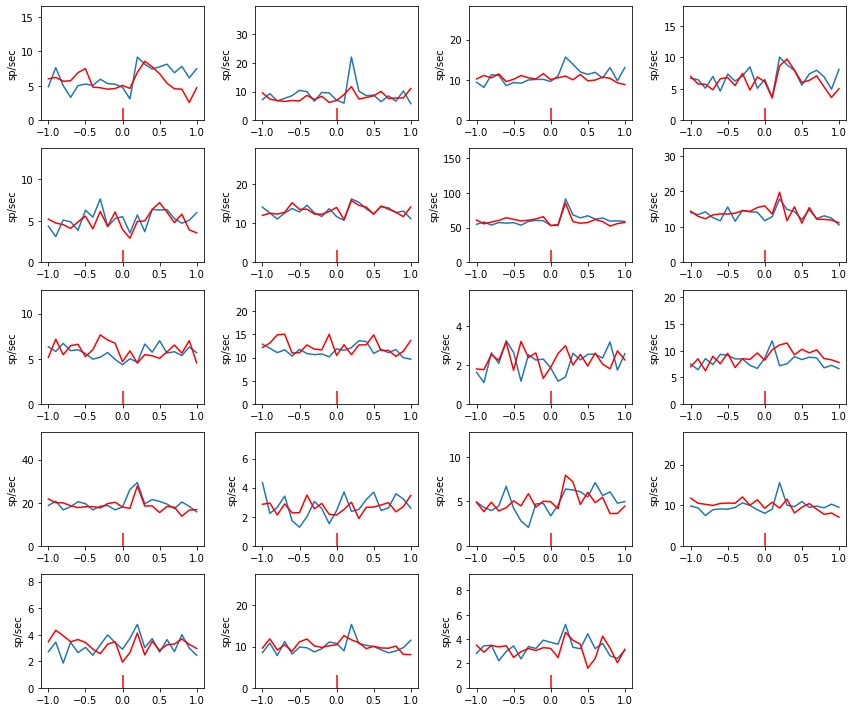

In [70]:
# calculate saccade-locked psth

spike_corr = 1 + 0.125/1200  # correction factor for ephys timing drift
dEye= np.diff(th_switch)

fig = plt.figure(figsize = (12,np.ceil(n_units/2)))
trange = np.arange(-1,1.1,0.1)
sthresh = 5;
upsacc = eyeT[np.append(dEye,0)>sthresh]/spike_corr
upsacc = upsacc[upsacc>5]
upsacc = upsacc[upsacc<np.max(t)-5]
downsacc= eyeT[np.append(dEye,0)<-sthresh]/spike_corr
downsacc = downsacc[downsacc>5]
downsacc = downsacc[downsacc<np.max(t)-5]
upsacc_avg = np.zeros((units.size,trange.size))
downsacc_avg = np.zeros((units.size,trange.size))
for i, ind in enumerate(goodcells.index):
    rateInterp = interp1d(t[0:-1],goodcells.at[ind,'rate'])
    for s in upsacc:
        upsacc_avg[i,:] = upsacc_avg[i,:]+ rateInterp(np.array(s)+trange)/upsacc.size
    for s in downsacc:
        downsacc_avg[i,:]= downsacc_avg[i,:]+ rateInterp(np.array(s)+trange)/downsacc.size
    plt.subplot(np.ceil(n_units/4),4,i+1)
    plt.plot(trange,upsacc_avg[i,:])
    plt.plot(trange,downsacc_avg[i,:],'r')
    plt.vlines(0,0,np.max(upsacc_avg[i,:]*0.2),'r')
    plt.ylim([0, np.max(upsacc_avg[i,:])*1.8])
    plt.ylabel('sp/sec')
plt.tight_layout()
plt.savefig(name_base + '_saccade.pdf')
        


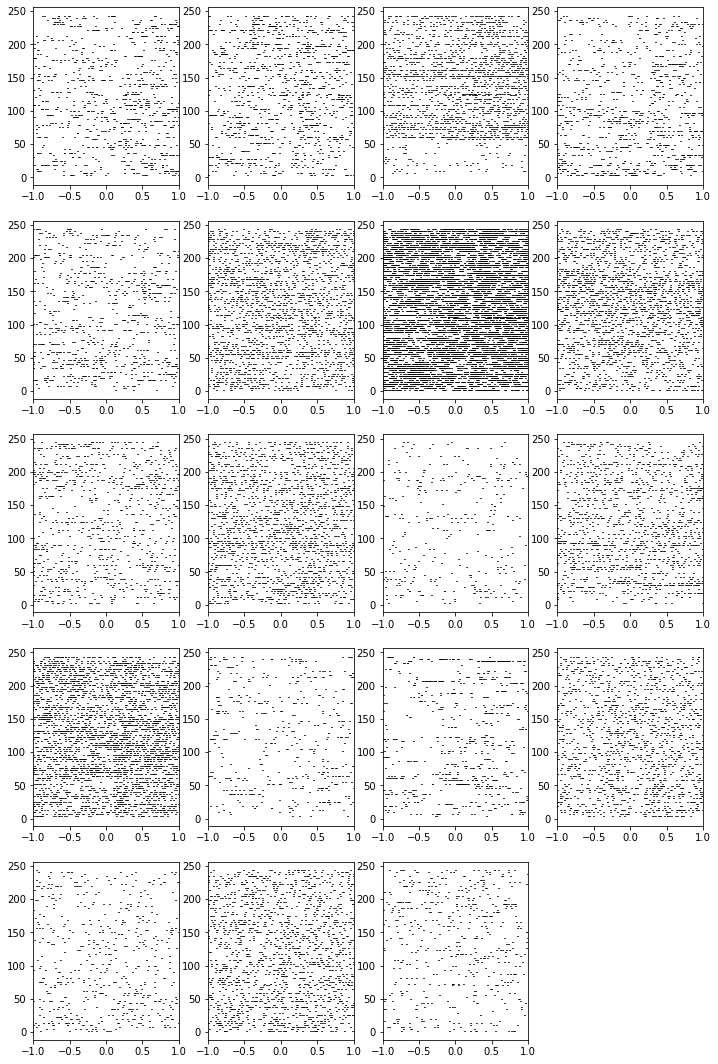

In [71]:
# rasters around positive saccades
fig = plt.figure(figsize = (12,n_units)) 
for i, ind in enumerate(goodcells.index): 
    sp = np.array(goodcells.at[units[i],'spikeT']) *spike_corr
    plt.subplot(np.ceil(n_units/4),4,i+1) 
    n = 0 
    for s in upsacc: 
        n= n+1 
        sd = np.abs(sp-np.array(s))<10 
        sacc_sp = sp[sd] 
        plt.vlines(sacc_sp-np.array(s),n-0.25,n+0.25) 
    plt.xlim(-1,1); #plt.ylim(0,50)

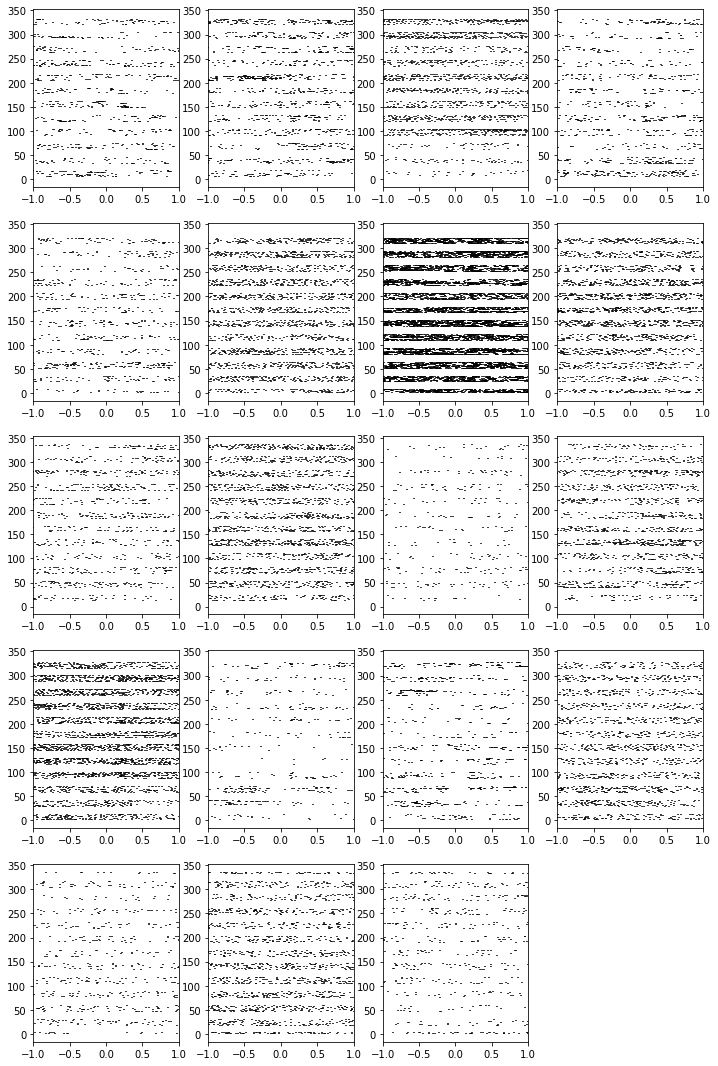

In [72]:
#rasters around negative saccades
fig = plt.figure(figsize = (12,n_units))
for i, ind in enumerate(goodcells.index):
    sp = np.array(goodcells.at[units[i],'spikeT'])
    plt.subplot(np.ceil(n_units/4),4,i+1)
    n = 0
    for s in downsacc:
        n= n+1
        sd = np.abs(sp-np.array(s))<10
        sacc_sp = sp[sd]
        plt.vlines(sacc_sp-np.array(s),n-0.25,n+0.25)
    plt.xlim(-1,1)

In [ ]:
# normalize and plot eye radius
eyeR = eye_params.sel(ellipse_params = 'longaxis').copy()
Rnorm = (eyeR - np.mean(eyeR))/np.std(eyeR)
plt.plot(eyeT,Rnorm)
plt.xlim([0,60])
plt.xlabel('secs')
plt.ylabel('normalized pupil R')


In [ ]:
plt.hist(Rnorm)
plt.xlabel('normalized pupil R')
plt.ylabel('#')

In [ ]:
# plot rate vs pupil
n_units = len(goodcells)
R_range = np.arange(-4,4,0.5)
useEyeT = eyeT[(eyeT<t[-2]) & (eyeT>t[0])].copy()
useR = Rnorm[(eyeT<t[-2]) & (eyeT>t[0])].copy()
R_scatter = np.zeros((n_units,len(useR)))
R_tuning = np.zeros((n_units,len(R_range)-1))
R_tuning_err =R_tuning.copy()
for i, ind in enumerate(goodcells.index):
    rateInterp = interp1d(t[0:-1],goodcells.at[ind,'rate'])
    R_scatter[i,:] = rateInterp(useEyeT)
    for j in range(len(R_range)-1):
        usePts =(useR>R_range[j]) & (useR<R_range[j+1])
        R_tuning[i,j] = np.mean(R_scatter[i,usePts])
        R_tuning_err[i,j] = np.std(R_scatter[i,usePts])/np.sqrt(np.count_nonzero(usePts))

fig = plt.figure(figsize = (12,np.ceil(n_units/2)))
for i in range(n_units):
    plt.subplot(np.ceil(n_units/4),4,i+1)
    plt.errorbar(R_range[:-1],R_tuning[i,:],yerr=R_tuning_err[i,:])
    plt.ylim(0,np.nanmax(R_tuning[i,2:-2]*1.2))
    plt.xlim([-2, 2])
    plt.xlabel('normalized pupil R'); plt. ylabel('sp/sec'); plt.title(i)
        
        
plt.tight_layout()

plt.savefig(name_base + '_pupil_R.pdf')

In [ ]:
# normalize eye position
eyeTheta = eye_params.sel(ellipse_params = 'theta').copy()
thetaNorm = (eyeTheta - np.mean(eyeTheta))/np.std(eyeTheta)
plt.plot(eyeT[0:3600],thetaNorm[0:3600])
plt.xlabel('secs'); plt.ylabel('normalized eye theta')

In [ ]:
# plot rate vs theta
n_units = len(goodcells)
th_range = np.arange(-2,3,0.5)
useEyeT = eyeT[(eyeT<t[-2]) & (eyeT>t[0])].copy()
useTh = thetaNorm[(eyeT<t[-2]) & (eyeT>t[0])].copy()
th_scatter = np.zeros((n_units,len(useR)))
th_tuning = np.zeros((n_units,len(th_range)-1))
th_tuning_err =th_tuning.copy()
for i, ind in enumerate(goodcells.index):
    rateInterp = interp1d(t[0:-1],goodcells.at[ind,'rate'])
    th_scatter[i,:] = rateInterp(useEyeT)
    for j in range(len(th_range)-1):
        usePts =(useTh>th_range[j]) & (useTh<th_range[j+1])
        th_tuning[i,j] = np.mean(th_scatter[i,usePts])
        th_tuning_err[i,j] = np.std(th_scatter[i,usePts])/np.sqrt(np.count_nonzero(usePts))

fig = plt.figure(figsize = (3*np.ceil(n_units/2),6))
for i in range(n_units):
    plt.subplot(2,np.ceil(n_units/2),i+1)
    plt.errorbar(th_range[:-1],th_tuning[i,:],yerr=th_tuning_err[i,:])
    plt.ylim(0,np.nanmax(th_tuning[i,:]*1.2))
    plt.xlim([-2, 2])
    plt.xlabel('normalized pupil theta'); plt. ylabel('sp/sec'); plt.title(i)
        
        
plt.tight_layout()

plt.savefig(name_base + '_pupil_theta.pdf')

In [ ]:
# generate summary plot

samprate = 30000  # ephys sample rate
plt.figure(figsize = (12,np.ceil(n_units)*2))
for i, ind in enumerate(goodcells.index): 
    # plot waveform
    plt.subplot(n_units,4,i*4 + 1)
    wv = goodcells.at[ind,'waveform']
    plt.plot(np.arange(len(wv))*1000/samprate,goodcells.at[ind,'waveform'])
    plt.xlabel('msec'); plt.title(str(i) + ' ' + goodcells.at[ind,'KSLabel']  +  ' cont='+ str(goodcells.at[ind,'ContamPct']))
    
    # plot CRF
    plt.subplot(n_units,4,i*4 + 2)
    plt.plot(crange[2:-1],resp[i,2:-1])
    plt.xlabel('contrast a.u.'); plt.ylabel('sp/sec'); plt.ylim([0,np.nanmax(resp[i,2:-1])])
                                  
    #plot STA
    plt.subplot(n_units,4,i*4 + 3)
    sta = staAll[i,:,:]
    staRange = np.max(np.abs(sta))*1.2
    if staRange<0.25:
        staRange=0.25
    plt.imshow(staAll[i,:,:],vmin = -staRange, vmax= staRange, cmap = 'jet')
                                  
    #plot eye movements
    plt.subplot(n_units,4,i*4 + 4)
    plt.plot(trange,upsacc_avg[i,:])
    plt.plot(trange,downsacc_avg[i,:],'r')
    plt.vlines(0,0,np.max(upsacc_avg[i,:]*0.2),'r')
    plt.ylim([0, np.max(upsacc_avg[i,:])*1.8])
    plt.ylabel('sp/sec')
plt.tight_layout()
plt.savefig(name_base + "_overview.pdf")                                 
                                 
                                  
                                  

In [ ]:
goodcells

In [ ]:
rnage(len(wv))

In [ ]:
np.arange(len(wv))